In [87]:
import math
import numpy as np
import pandas as pd
import pickle
import pydotplus
import seaborn as sns
import sys
import time
import warnings
import zipfile

from collections import (Counter,)
from imblearn.under_sampling \
    import (RandomUnderSampler,
            ClusterCentroids,
            TomekLinks,)
from imblearn.over_sampling \
    import (RandomOverSampler,
            SMOTE,)
from io import (StringIO,)
from IPython.display import (Image,)
from matplotlib import (pyplot as plt,)
from mlxtend.classifier import (StackingClassifier,)
from scipy import (stats,)
from scipy.cluster import (hierarchy as sch,)
from sklearn.cluster \
    import (KMeans,
            AgglomerativeClustering,)
from sklearn.datasets import (make_moons,)
from sklearn.decomposition import (PCA,) 
from sklearn.ensemble \
    import (AdaBoostClassifier,
            BaggingClassifier,
            ExtraTreesClassifier,
            GradientBoostingClassifier,
            RandomForestClassifier,
            VotingClassifier,)
from sklearn.feature_selection \
    import (chi2,
            f_regression,
            f_classif,
            RFE,
            SelectFromModel,
            SelectKBest,
            SelectPercentile,)
from sklearn.linear_model \
    import (Lasso,
            LogisticRegression,
            LinearRegression,
            Ridge,)
from sklearn.metrics \
    import (accuracy_score,
            auc,
            classification_report,
            confusion_matrix,
            f1_score,
            precision_score,
            precision_recall_fscore_support as error_metric,
            r2_score,
            recall_score,
            roc_auc_score,
            roc_curve,)
from sklearn.model_selection \
    import (GridSearchCV,
            RandomizedSearchCV,
            train_test_split,)
from sklearn.multiclass import (OneVsRestClassifier,)
from sklearn.pipeline import (make_pipeline,)
from sklearn.preprocessing \
    import (LabelEncoder,
            MinMaxScaler,
            StandardScaler,)
from sklearn.svm \
    import (LinearSVC,
            LinearSVC,
            SVC,)
from sklearn.tree \
    import (DecisionTreeClassifier,
            DecisionTreeRegressor,)
from xgboost import (XGBClassifier,)

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

%config InlineBackend.figure_format ='retina'

In [88]:
def plot_auc(y_test, y_pred):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def get_scores(model, X_test, y_test,):
    y_pred = model.best_estimator_.predict(X_test,)
    print("Accuracy: {0}".format(accuracy_score(y_test, y_pred,)))
    print("\n")
    print("Recall: {0}".format(recall_score(y_test, y_pred,)))
    print("Precision: {0}".format(precision_score(y_test, y_pred,)))
    print("F1 Score: {0}".format(f1_score(y_test, y_pred,)))
    print("\n")
    print("ROC AUC: {0}".format(roc_auc_score(y_test, y_pred,)))
    print("\n")
    print("Confusion Matrix: \n{0}".format(confusion_matrix(y_test, y_pred,)))
    print("\n")
    print("Classification Report: \n{0}".format(classification_report(y_test, y_pred,)))
    plot_auc(y_test, y_pred)
    
def get_results_df(gscv_model,):
    # Creating a dictionary out of the GridSearchCV results
    results_dict = {}
    results = gscv_model.cv_results_
    
    for key in results.keys():
        if type(results[key]) == np.ndarray:
            results_dict[key] = list(results[key])
            
        elif type(results[key]) == np.ma.core.MaskedArray:
            results_dict[key] = list(results[key])
            
        elif type(results[key]) == list:
            pass
            # Accidentally wrote code for something that already exists.
            # Might as well keep it for later
#             if type(results[key][0]) == dict:
#                 cumulated_dict = {}
#                 for dict_key in results[key][0].keys():
#                     cumulated_dict[f'{key}_{dict_key}'] = []
#                 for dict_key in results[key][0].keys():
#                     for entry in results[key]:
#                         cumulated_dict[f'{key}_{dict_key}'].append(str(entry[dict_key]))
#                 for dict_key in results[key][0].keys():
#                     results_dict[f'{key}_{dict_key}'] = cumulated_dict[f'{key}_{dict_key}']
        else:
            print("Unkown type encountered")
        
    return_df = pd.DataFrame(data=results_dict,)
    
#     if return_df.isnull().sum().max() > 0:
#         print("Incorrect model training values have been omitted")
#         print("{0} values".format(return_df.isnull().sum().max()))
#     return_df.dropna(axis=0, inplace=True)
    
    return return_df

def train_model(model, hyperparameters, scoring_, filename):
    gscv_model = GridSearchCV(model, hyperparameters, cv=10, verbose=0, scoring=scoring_, n_jobs=-1, return_train_score=True,)

    try:
        with open(file_name, 'rb') as handle:
            gscv_model = pickle.load(handle)
        print("Found trained model file with same name. Loading it instead.")
    except:
        start_time = time.time()

        gscv_model.fit(X_train, y_train,)

        time_taken_s = np.around(time.time()-start_time, decimals=2,)
        time_taken_m = time_taken_s/60  
        print('Total Time taken = {0} seconds \nIn minutes: {1}'.format(time_taken_s, time_taken_m,))

        with open(file_name, 'wb') as handle:
            pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    return gscv_model

def get_data(data_type_code):
    
    X_train, X_test, y_train, y_test = ["", "", "", "",]
    
    # Unmodified Data
    if data_type_code==1:
        X, y = pd.read_csv("X_cleaned.csv").iloc[:,1:], pd.read_csv("y_cleaned.csv").iloc[:,1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4, stratify=y,)
    
    # Undersample Data
    elif data_type_code==2:
#         X, y = pd.read_csv("X_undersampled.csv").iloc[:,1:], pd.read_csv("y_undersampled.csv").iloc[:,1]
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4, stratify=y,)
        X_train = pd.read_csv('X_train_undersampled.csv').iloc[:, 1:]
        X_test = pd.read_csv('X_test_undersampled.csv').iloc[:, 1:]
        y_train = pd.read_csv('y_train_undersampled.csv').iloc[:, 1]
        y_test = pd.read_csv('y_test_undersampled.csv').iloc[:, 1]
    
    # Oversampled Data
    elif data_type_code==3:
        X_train = pd.read_csv('X_train_oversampled.csv').iloc[:, 1:]
        X_test = pd.read_csv('X_test_oversampled.csv').iloc[:, 1:]
        y_train = pd.read_csv('y_train_oversampled.csv').iloc[:, 1]
        y_test = pd.read_csv('y_test_oversampled.csv').iloc[:, 1]
    
    # SMOTE Data
    elif data_type_code==4:
        X_train = pd.read_csv('X_train_smote.csv').iloc[:, 1:]
        X_test = pd.read_csv('X_test_smote.csv').iloc[:, 1:]
        y_train = pd.read_csv('y_train_smote.csv').iloc[:, 1]
        y_test = pd.read_csv('y_test_smote.csv').iloc[:, 1]
    
    else:
        raise Exception('Wrong Data Code')
        

    return [X_train, X_test, y_train, y_test]
    

$Decision$ $Tree$ $Classifier$

Found trained model file with same name. Loading it instead.
For unmodified data :
y_train: 35385
	Class 0: 34866, Class 1: 519
y_test: 15166
	Class 0: 14944, Class 1: 222
Accuracy: 0.9697349334036661


Recall: 0.07207207207207207
Precision: 0.05947955390334572
F1 Score: 0.06517311608961303


ROC AUC: 0.5275711002758646


Confusion Matrix: 
[[14691   253]
 [  206    16]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     14944
           1       0.06      0.07      0.07       222

    accuracy                           0.97     15166
   macro avg       0.52      0.53      0.52     15166
weighted avg       0.97      0.97      0.97     15166



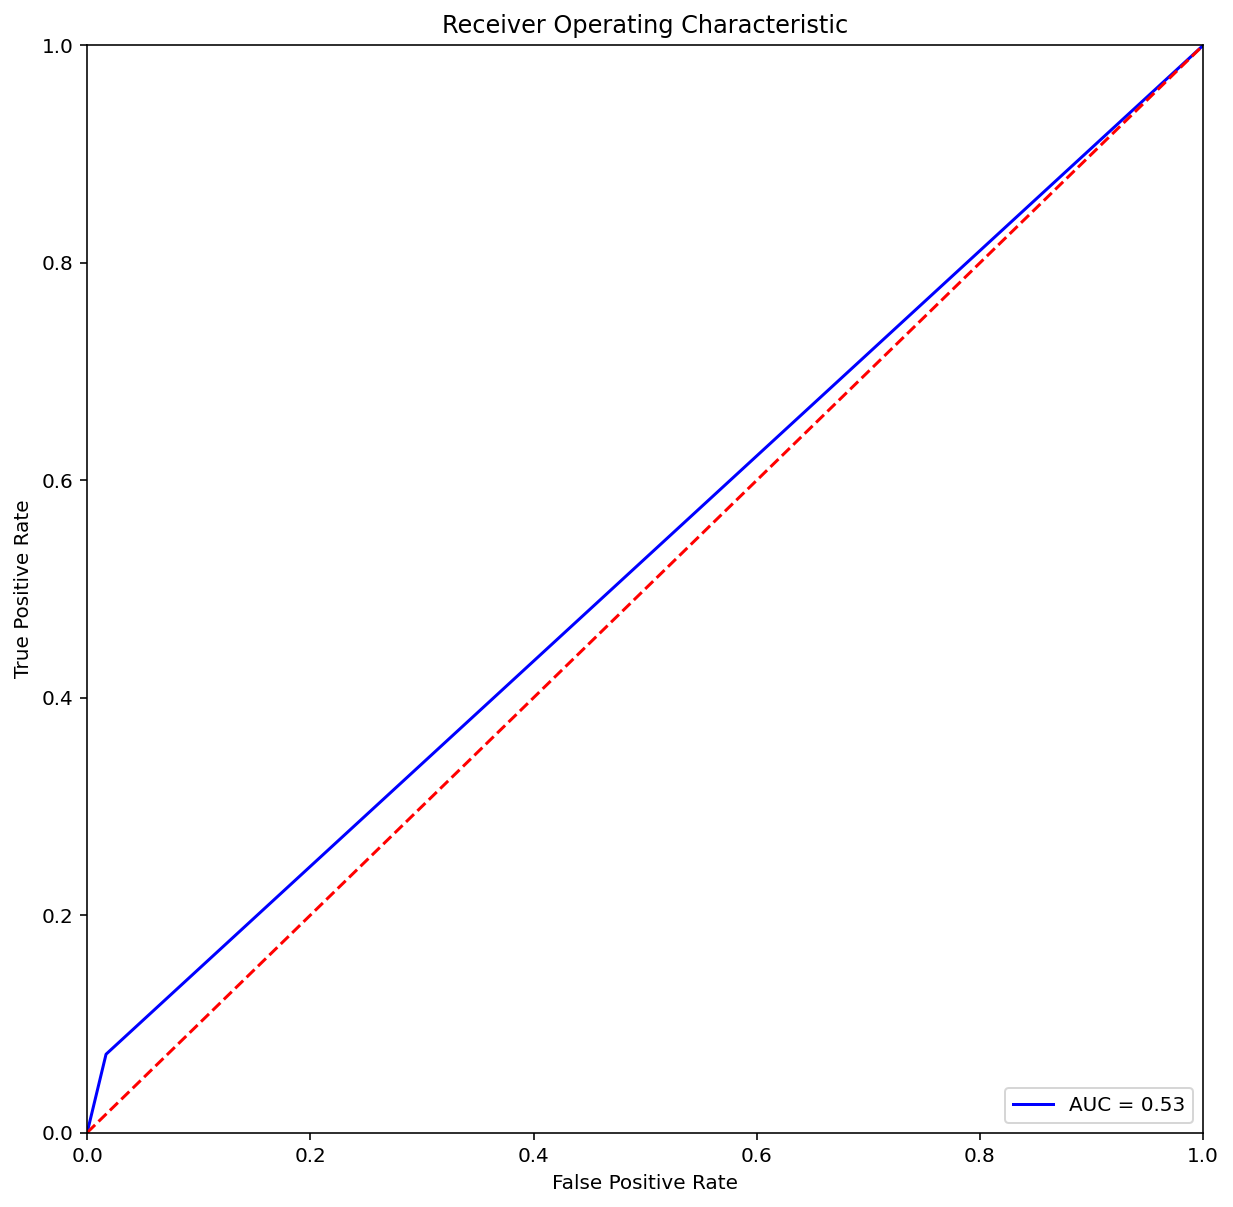

Found trained model file with same name. Loading it instead.
For undersampled data :
y_train: 1038
	Class 0: 519, Class 1: 519
y_test: 15166
	Class 0: 14944, Class 1: 222
Accuracy: 0.6746010813662139


Recall: 0.6126126126126126
Precision: 0.02728184553660983
F1 Score: 0.052237372767428465


ROC AUC: 0.6440672806103748


Confusion Matrix: 
[[10095  4849]
 [   86   136]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.68      0.80     14944
           1       0.03      0.61      0.05       222

    accuracy                           0.67     15166
   macro avg       0.51      0.64      0.43     15166
weighted avg       0.98      0.67      0.79     15166



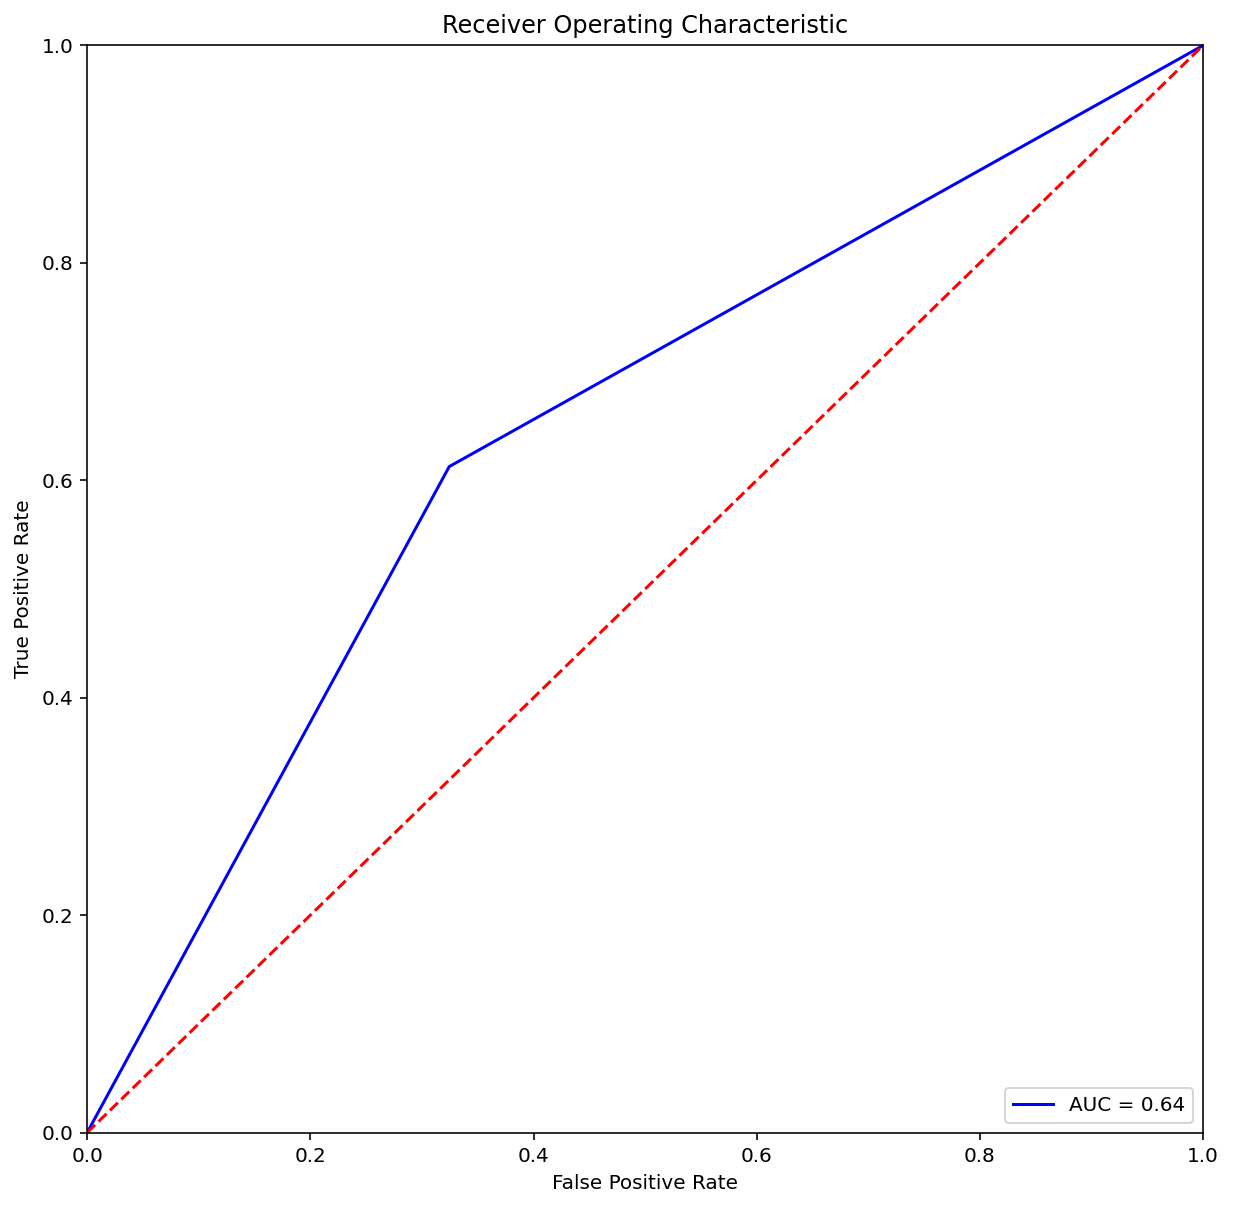

Found trained model file with same name. Loading it instead.
For oversampled data :
y_train: 69756
	Class 0: 34878, Class 1: 34878
y_test: 15166
	Class 0: 14932, Class 1: 234
Accuracy: 0.9718449162600554


Recall: 0.0641025641025641
Precision: 0.06726457399103139
F1 Score: 0.06564551422319474


ROC AUC: 0.525086374470248


Confusion Matrix: 
[[14724   208]
 [  219    15]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14932
           1       0.07      0.06      0.07       234

    accuracy                           0.97     15166
   macro avg       0.53      0.53      0.53     15166
weighted avg       0.97      0.97      0.97     15166



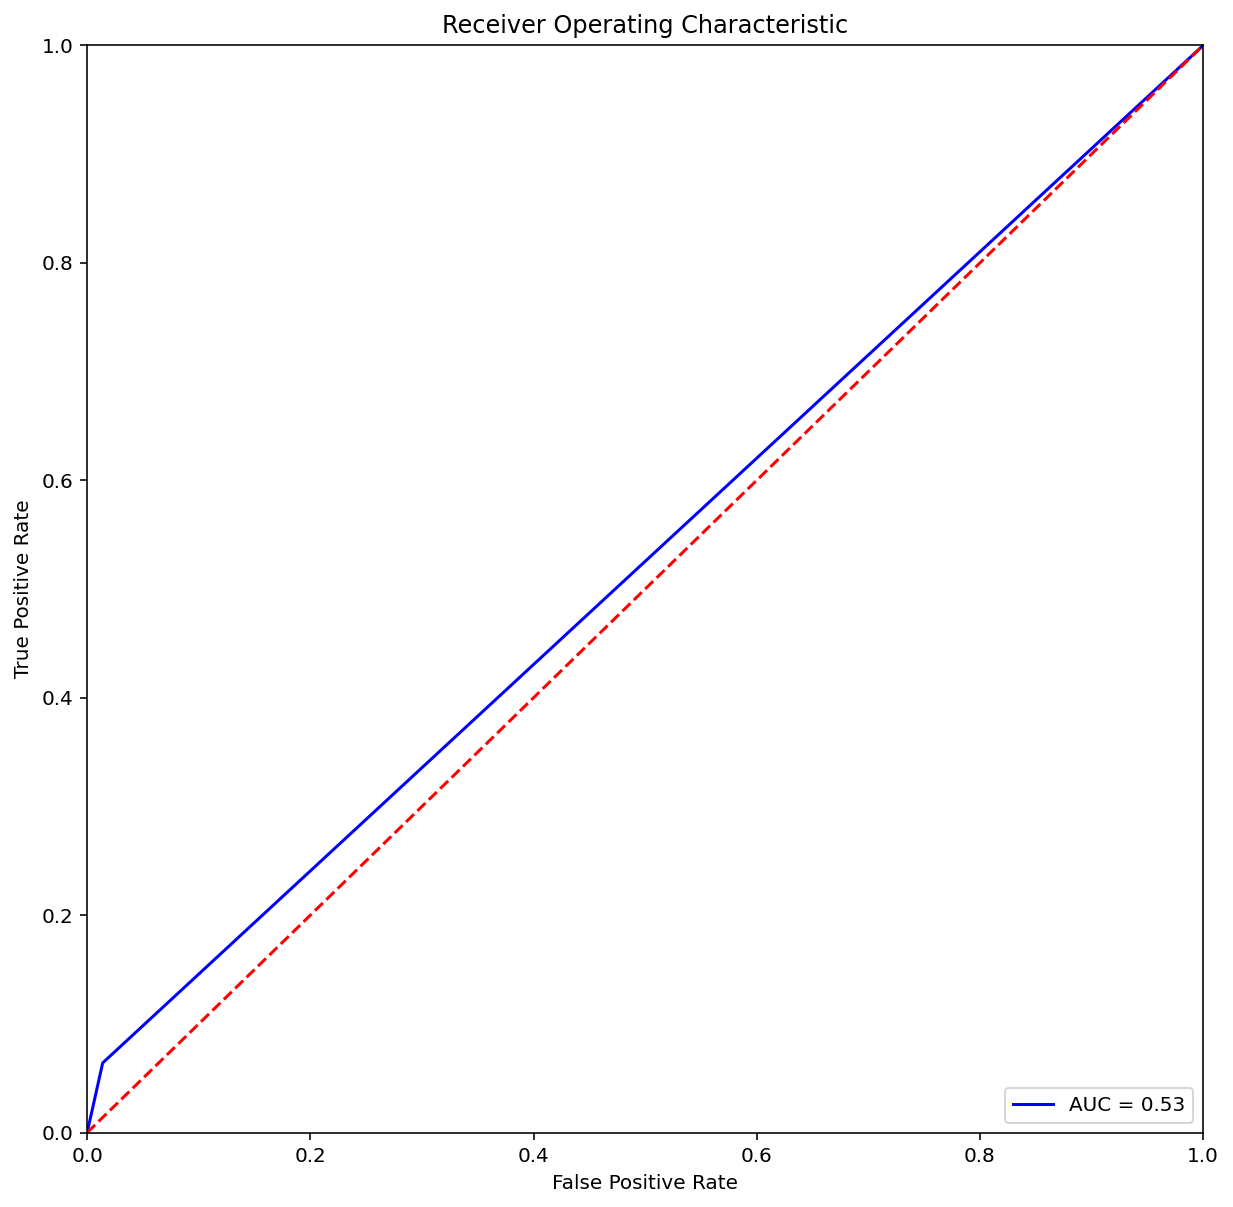

Found trained model file with same name. Loading it instead.
For smote data :
y_train: 69756
	Class 0: 34878, Class 1: 34878
y_test: 15166
	Class 0: 14932, Class 1: 234
Accuracy: 0.9504154028748516


Recall: 0.20512820512820512
Precision: 0.0781758957654723
F1 Score: 0.11320754716981131


ROC AUC: 0.5836115175118657


Confusion Matrix: 
[[14366   566]
 [  186    48]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     14932
           1       0.08      0.21      0.11       234

    accuracy                           0.95     15166
   macro avg       0.53      0.58      0.54     15166
weighted avg       0.97      0.95      0.96     15166



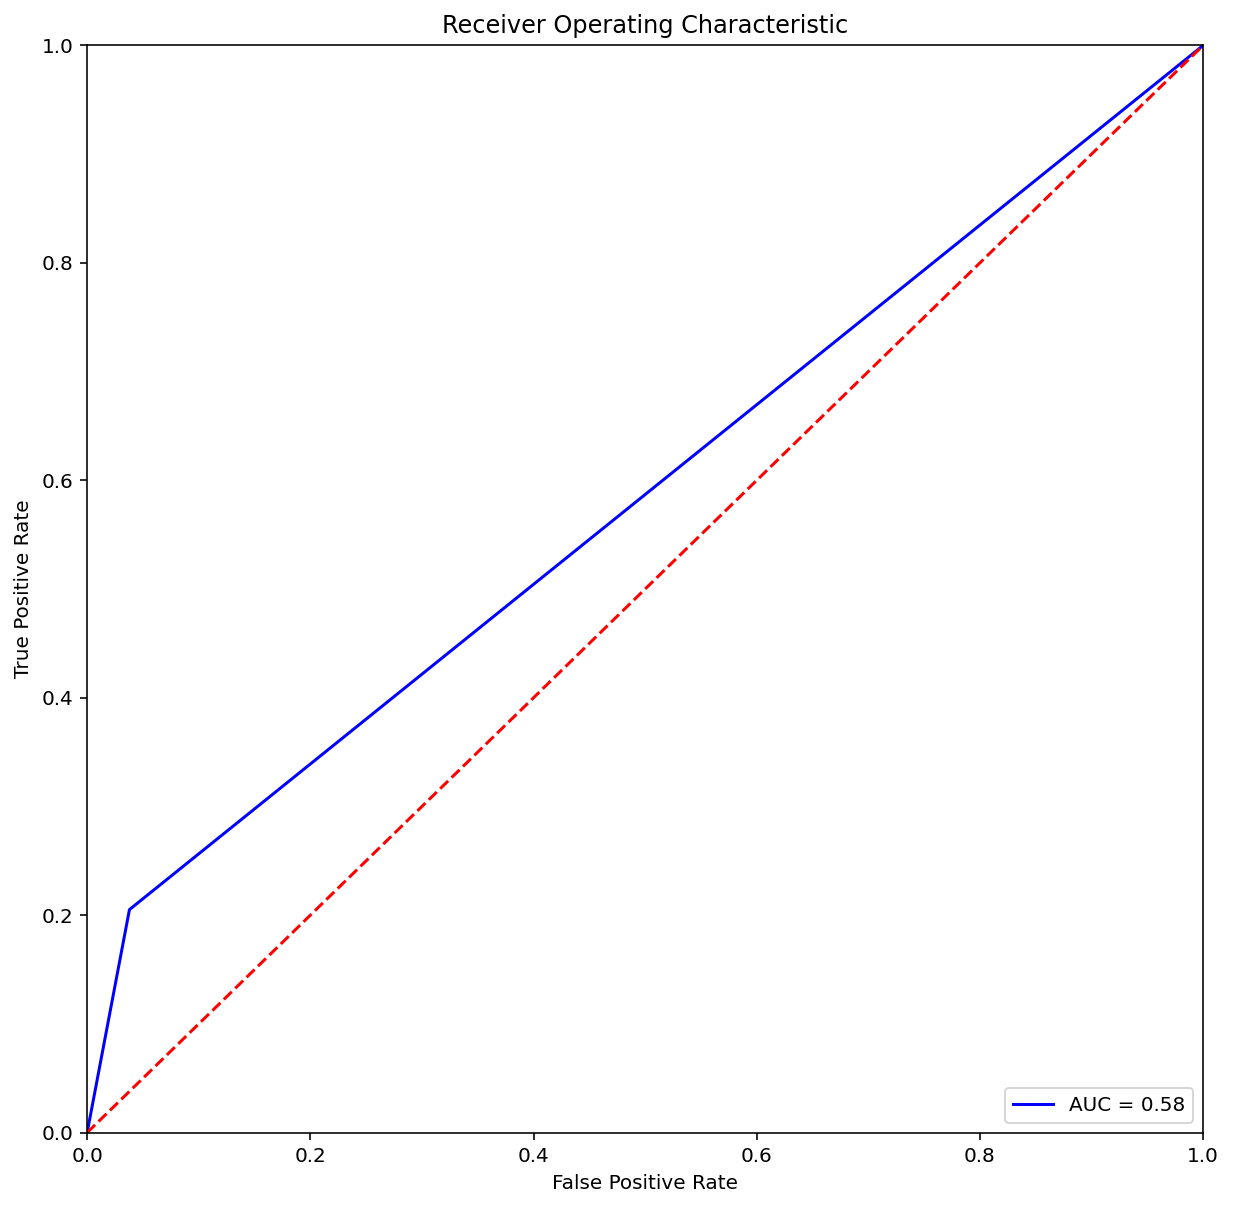

In [89]:
for data_code, code_string in zip(range(1,5), ['unmodified', 'undersampled', 'oversampled', 'smote']):
    
    X_train, X_test, y_train, y_test = get_data(data_code)
    
    model = DecisionTreeClassifier(random_state=4)

    hyperparameters = {
        'criterion': ['gini', 'entropy',],
        'splitter': ['best', 'random',],
        'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10},]
    }

    scoring = "roc_auc"

    file_name = f'trained_model_dtree_{data_code}{code_string}.pickle'

    gscv_model = train_model(model, hyperparameters, scoring, file_name,)
    
    print("="*60)
    print(f"For {code_string} data :")
    print(f'y_train: {len(y_train)}')
    print('\tClass 0: {0}, Class 1: {1}'.format(len(y_train[y_train==0]), len(y_train[y_train==1]),))
    
    print(f'y_test: {len(y_test)}')
    print(f'\tClass 0: {len(y_test[y_test==0])}, Class 1: {len(y_test[y_test==1])}')
    print("="*60)
    
    results_df = get_results_df(gscv_model)
#     print(results_df.head(4).T)
#     print(results_df.sort_values(by='rank_test_score', ascending=True).iloc[0,:].T)
    get_scores(gscv_model, X_test, y_test,)

Found trained model file with same name. Loading it instead.
Accuracy: 0.862455492549123


Recall: 0.5630630630630631
Precision: 0.05912961210974456
F1 Score: 0.10702054794520549


ROC AUC: 0.7149830839940582


Confusion Matrix: 
[[12955  1989]
 [   97   125]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     14944
           1       0.06      0.56      0.11       222

    accuracy                           0.86     15166
   macro avg       0.53      0.71      0.52     15166
weighted avg       0.98      0.86      0.91     15166



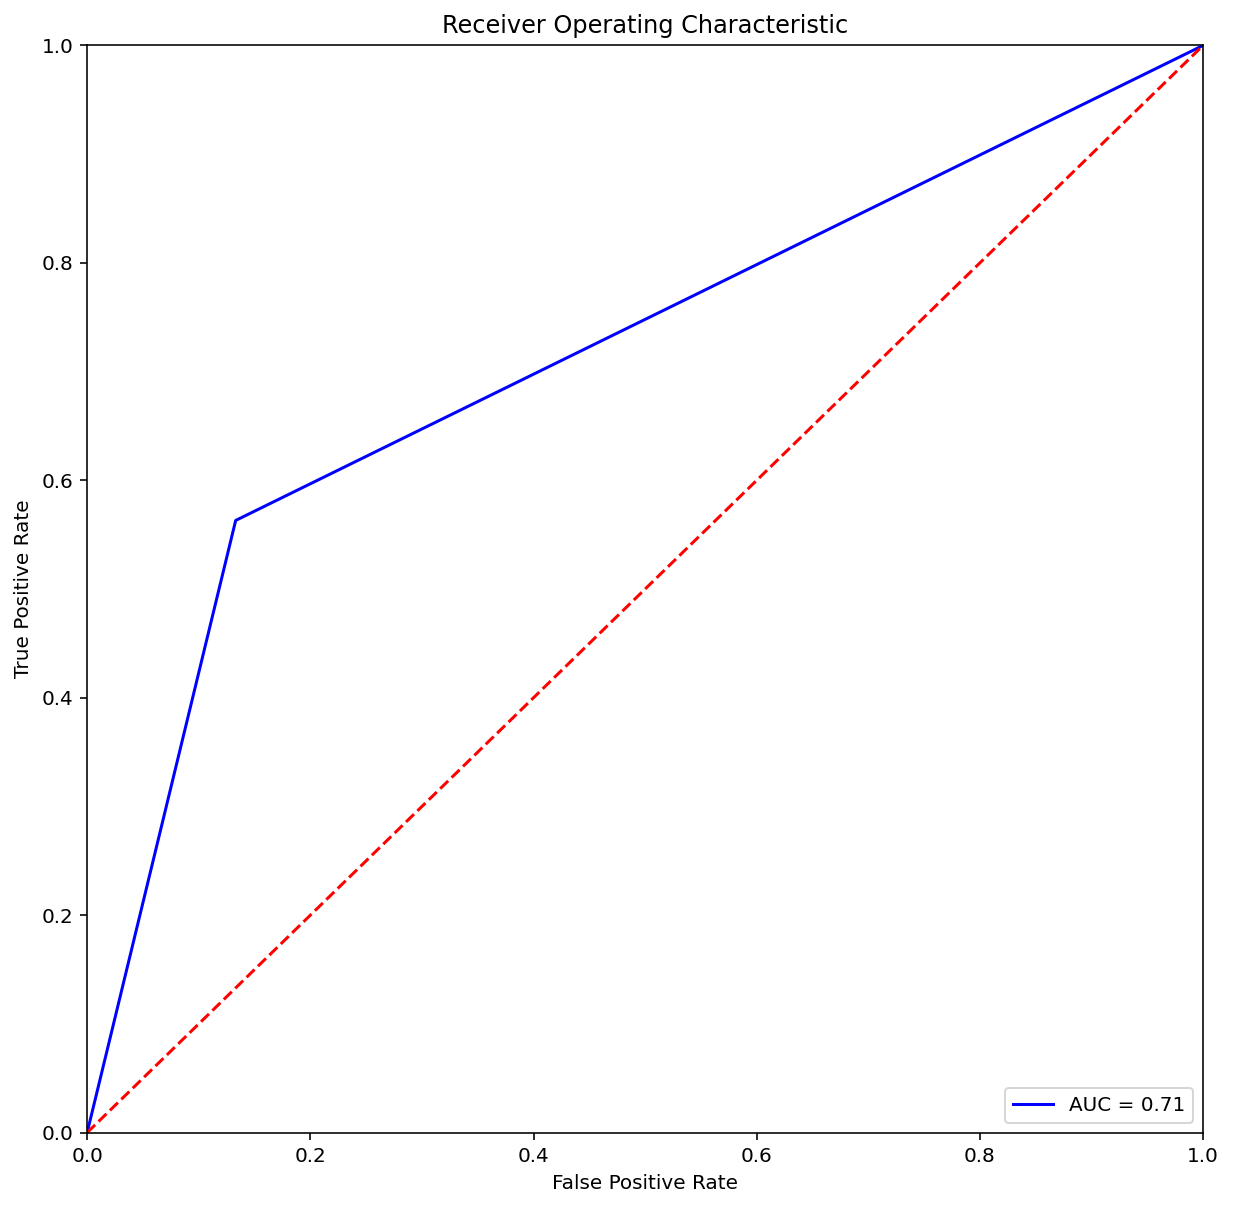

In [90]:
X_train, X_test, y_train, y_test = get_data(1)

hyperparameters = {
        'criterion': ['gini', 'entropy',],
        'splitter': ['best', 'random',],
        'max_depth': [None, 5, 10, 20, 50,],
        'min_samples_split': [2, 5, 10, 50, 100,],
        'min_samples_leaf': [1, 5, 10, 50, 100,],
        'min_weight_fraction_leaf': [0.0, 0.1, 0.5, 0.75,],
        'max_features': [None, "auto", "sqrt", "log2",],
        'random_state': [4,],
        'max_leaf_nodes': [None, 1, 2, 5, 10, 20,],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1, 0.2, 0.5,],
        'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25},],
        'ccp_alpha': [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5,],
    }

model = DecisionTreeClassifier()

# model_cv = GridSearchCV(estimator = model,
#                         param_grid = hyperparameters,
#                         scoring="roc_auc",
#                         n_jobs=-1,
#                         cv = 10,
#                         verbose=2,
#                         return_train_score=True,
#                        )

file_name = 'dtc_rscv_1.pickle'

try:
    with open(file_name, 'rb') as handle:
        model_cv = pickle.load(handle)
        print("Found trained model file with same name. Loading it instead.")
except:
    model_cv = RandomizedSearchCV(estimator=model,
                                  param_distributions=hyperparameters,
                                  n_iter=10000,
                                  scoring="roc_auc",
                                  n_jobs=-1,
                                  cv=10,
                                  verbose=2,
                                  random_state=4,
                                  return_train_score=False,
                                 )

    model_cv.fit(X_train, y_train,)
    with open(file_name, 'wb') as handle:
        pickle.dump(model_cv, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Model Saved.")

get_scores(model_cv, X_test, y_test,)

In [101]:
results = get_results_df(model_cv,).sort_values(by='rank_test_score', ascending=True,)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
5300,0.024420,0.002066,0.003183,0.000401,random,4,0.00,10,5,0.00,...,0.826623,0.837363,0.745061,0.856856,0.778617,0.827395,0.782771,0.806706,0.034004,1
3840,0.045904,0.003110,0.002697,0.000460,best,4,0.00,2,100,0.00,...,0.831274,0.848048,0.750865,0.800521,0.767979,0.846242,0.798218,0.806023,0.029713,2
9522,0.025161,0.001431,0.002791,0.000600,best,4,0.00,5,10,0.00,...,0.801648,0.845688,0.775733,0.809656,0.757414,0.837134,0.791956,0.805292,0.025543,3
3256,0.024495,0.002203,0.003485,0.001461,best,4,0.00,10,100,0.00,...,0.806647,0.845688,0.773759,0.806663,0.753655,0.837134,0.785720,0.804358,0.026824,4
7587,0.047331,0.011177,0.003617,0.001484,best,4,0.00,2,5,0.00,...,0.800636,0.840733,0.766114,0.817233,0.766605,0.839200,0.818640,0.803736,0.031928,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,0.011905,0.002646,0.000000,0.000000,best,4,0.75,50,1,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9996
2472,0.013483,0.004026,0.000000,0.000000,best,4,0.10,10,5,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9997
2473,0.012965,0.002170,0.000000,0.000000,random,4,0.00,100,50,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9998
6463,0.011710,0.000902,0.000000,0.000000,random,4,0.50,10,100,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999


In [129]:
def abc(min_weight_fraction_leaf, min_impurity_decrease, ccp_alpha, min_samples_split, min_samples_leaf, max_leaf_nodes,max_depth):
    X_train, X_test, y_train, y_test = get_data(1)

    model_plus = DecisionTreeClassifier(splitter='best',
                                   criterion = 'entropy',
                                   max_features = None,
                                   class_weight = {0: 1, 1: 5},
                                   random_state=4,

                                   min_weight_fraction_leaf = 0.0 +min_weight_fraction_leaf,
                                   min_impurity_decrease = 0.0 +min_impurity_decrease,
                                   ccp_alpha = 0.001 +ccp_alpha,

                                   min_samples_split = 2 +min_samples_split,
                                   min_samples_leaf = 100 +min_samples_leaf,
                                   max_leaf_nodes = 10 +max_leaf_nodes,
                                   max_depth = 5 +max_depth,
                                  )
    model_minus = DecisionTreeClassifier(splitter='best',
                                   criterion = 'entropy',
                                   max_features = None,
                                   class_weight = {0: 1, 1: 5},
                                   random_state=4,

                                   min_weight_fraction_leaf = 0.0 -min_weight_fraction_leaf,
                                   min_impurity_decrease = 0.0 -min_impurity_decrease,
                                   ccp_alpha = 0.001 -ccp_alpha,

                                   min_samples_split = 2 -min_samples_split,
                                   min_samples_leaf = 100 -min_samples_leaf,
                                   max_leaf_nodes = 10 -max_leaf_nodes,
                                   max_depth = 5 -max_depth,
                                  )

    target_score = 0.7149830839940582

    a = model_plus.fit(X_train, y_train,)
    b = model_minus.fit(X_train, y_train,)

    auc_plus = roc_auc_score(y_true=y_test, y_score=model_plus.predict(X_test))
    auc_minus = roc_auc_score(y_true=y_test, y_score=model_minus.predict(X_test))

    print(f'Target: {target_score}')
    print(f'Plus: {auc_plus}')
    if auc_plus == auc_minus:
        print("=")
    print(f'Minus: {auc_minus}')

    if (auc_plus > target_score) & (auc_plus > auc_minus):
        print("Plus")
    elif (auc_minus > target_score) & (auc_minus > auc_plus):
        print("Minus")
    elif (auc_minus < target_score) & (auc_plus < target_score):
        print("Both Bad")
    elif (auc_minus > target_score) & (auc_plus > target_score) & (auc_plus == auc_minus):
        print("Both Better")
        
        
min_weight_fraction_leaf = 0.0
min_impurity_decrease = 0.0
ccp_alpha = 0.0

min_samples_split = 0
min_samples_leaf = 0
max_leaf_nodes = 0
max_depth = 4


abc(min_weight_fraction_leaf, min_impurity_decrease, ccp_alpha, min_samples_split, min_samples_leaf, max_leaf_nodes,max_depth)

Target: 0.7149830839940582
Plus: 0.5352206797268361
Minus: 0.5
Both Bad


In [92]:
results1.drop(results1.tail(len(results1)-10).index)[[i for i in results1.columns if 'param' in i]]

,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
5300,random,4,0.0,10,5,0.0,20.0,None,NaN,entropy,"{0: 1, 1: 25}",0.000
3840,best,4,0.0,2,100,0.0,10.0,None,5.0,entropy,"{0: 1, 1: 5}",0.001
9522,best,4,0.0,5,10,0.0,10.0,log2,50.0,entropy,"{0: 1, 1: 10}",0.001
3256,best,4,0.0,10,100,0.0,10.0,log2,NaN,entropy,"{0: 1, 1: 5}",0.001
7587,best,4,0.0,2,5,0.0,NaN,auto,50.0,entropy,"{0: 1, 1: 25}",0.002
6037,best,4,0.0,2,1,0.0,10.0,None,50.0,gini,"{0: 1, 1: 25}",0.000
2090,random,4,0.0,2,1,0.0,20.0,None,5.0,entropy,"{0: 1, 1: 10}",0.002
662,random,4,0.0,5,1,0.0,20.0,None,5.0,entropy,"{0: 1, 1: 10}",0.002
5996,random,4,0.0,10,5,0.0,NaN,None,5.0,entropy,"{0: 1, 1: 10}",0.001
2635,random,4,0.0,10,10,0.0,NaN,None,50.0,entropy,"{0: 1, 1: 5}",0.001


In [93]:
results.iloc[0,:]

mean_fit_time                         0.0244196
std_fit_time                         0.00206591
mean_score_time                      0.00318341
std_score_time                      0.000401169
param_splitter                           random
param_random_state                            4
param_min_weight_fraction_leaf                0
param_min_samples_split                      10
param_min_samples_leaf                        5
param_min_impurity_decrease                   0
param_max_leaf_nodes                         20
param_max_features                         None
param_max_depth                             NaN
param_criterion                         entropy
param_class_weight                {0: 1, 1: 25}
param_ccp_alpha                               0
split0_test_score                      0.768191
split1_test_score                      0.831164
split2_test_score                       0.81302
split3_test_score                      0.826623
split4_test_score                      0

In [94]:
for x in [i for i in results.columns if 'param' in i]:
    print(x)

param_splitter
param_random_state
param_min_weight_fraction_leaf
param_min_samples_split
param_min_samples_leaf
param_min_impurity_decrease
param_max_leaf_nodes
param_max_features
param_max_depth
param_criterion
param_class_weight
param_ccp_alpha


In [95]:
results[[i 
         for i in results.columns 
         if 'split' not in i 
         and 'param' not in i 
         and 'std' not in i 
         and 'time' not in i]]

,mean_test_score,rank_test_score
5300,0.806706,1
3840,0.806023,2
9522,0.805292,3
3256,0.804358,4
7587,0.803736,5
...,...,...
6458,NaN,9996
2472,NaN,9997
2473,NaN,9998
6463,NaN,9999


In [96]:
for i in range(0,10):
    results[[i for i in results.columns if 'param' in i]].iloc[10*i:10*i+10, :]
    

,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
5300,random,4,0.0,10,5,0.0,20.0,None,NaN,entropy,"{0: 1, 1: 25}",0.000
3840,best,4,0.0,2,100,0.0,10.0,None,5.0,entropy,"{0: 1, 1: 5}",0.001
9522,best,4,0.0,5,10,0.0,10.0,log2,50.0,entropy,"{0: 1, 1: 10}",0.001
3256,best,4,0.0,10,100,0.0,10.0,log2,NaN,entropy,"{0: 1, 1: 5}",0.001
7587,best,4,0.0,2,5,0.0,NaN,auto,50.0,entropy,"{0: 1, 1: 25}",0.002
6037,best,4,0.0,2,1,0.0,10.0,None,50.0,gini,"{0: 1, 1: 25}",0.000
2090,random,4,0.0,2,1,0.0,20.0,None,5.0,entropy,"{0: 1, 1: 10}",0.002
662,random,4,0.0,5,1,0.0,20.0,None,5.0,entropy,"{0: 1, 1: 10}",0.002
5996,random,4,0.0,10,5,0.0,NaN,None,5.0,entropy,"{0: 1, 1: 10}",0.001
2635,random,4,0.0,10,10,0.0,NaN,None,50.0,entropy,"{0: 1, 1: 5}",0.001


,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
3874,random,4,0.0,2,1,0.0,10.0,log2,NaN,entropy,"{0: 1, 1: 25}",0.001
6634,best,4,0.0,2,50,0.0,20.0,None,5.0,entropy,"{0: 1, 1: 25}",0.001
9366,best,4,0.0,2,10,0.0,NaN,auto,10.0,entropy,"{0: 1, 1: 5}",0.001
2396,best,4,0.1,100,1,0.0,10.0,log2,20.0,entropy,"{0: 1, 1: 5}",0.000
5801,best,4,0.1,50,1,0.0,20.0,log2,50.0,entropy,"{0: 1, 1: 1}",0.000
7068,random,4,0.0,5,5,0.0,NaN,log2,50.0,entropy,"{0: 1, 1: 10}",0.001
6659,best,4,0.0,50,5,0.0,20.0,None,5.0,gini,"{0: 1, 1: 5}",0.000
8650,best,4,0.1,100,10,0.0,10.0,None,20.0,entropy,"{0: 1, 1: 25}",0.010
3520,best,4,0.1,2,50,0.0,20.0,None,NaN,gini,"{0: 1, 1: 10}",0.000
8427,best,4,0.0,10,5,0.0,5.0,None,NaN,entropy,"{0: 1, 1: 5}",0.000


,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
3821,best,4,0.1,10,100,0.00,5.0,None,NaN,gini,"{0: 1, 1: 25}",0.002
4353,best,4,0.1,100,10,0.00,20.0,None,NaN,gini,"{0: 1, 1: 25}",0.002
4212,best,4,0.0,5,5,0.01,NaN,None,50.0,entropy,"{0: 1, 1: 25}",0.010
5452,best,4,0.0,10,100,0.01,20.0,None,NaN,entropy,"{0: 1, 1: 25}",0.001
2313,best,4,0.0,10,1,0.01,5.0,None,20.0,entropy,"{0: 1, 1: 25}",0.005
6654,best,4,0.0,10,5,0.00,20.0,None,20.0,gini,"{0: 1, 1: 25}",0.000
3770,random,4,0.1,5,50,0.00,NaN,None,20.0,entropy,"{0: 1, 1: 10}",0.002
9966,random,4,0.0,5,1,0.00,NaN,None,5.0,entropy,"{0: 1, 1: 5}",0.000
9888,best,4,0.1,10,10,0.00,5.0,log2,50.0,entropy,"{0: 1, 1: 10}",0.001
515,best,4,0.1,10,1,0.00,10.0,log2,50.0,entropy,"{0: 1, 1: 10}",0.001


,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
9315,random,4,0.0,100,50,0.0,20.0,log2,NaN,entropy,"{0: 1, 1: 1}",0.000
6093,best,4,0.1,2,5,0.0,5.0,None,20.0,gini,"{0: 1, 1: 5}",0.000
4026,best,4,0.1,2,10,0.0,10.0,log2,NaN,entropy,"{0: 1, 1: 25}",0.001
624,random,4,0.1,10,10,0.0,10.0,None,NaN,gini,"{0: 1, 1: 1}",0.000
1660,best,4,0.1,5,10,0.0,NaN,log2,50.0,gini,"{0: 1, 1: 5}",0.000
1072,random,4,0.1,50,100,0.0,5.0,None,20.0,entropy,"{0: 1, 1: 25}",0.005
3358,random,4,0.1,100,5,0.0,10.0,None,50.0,entropy,"{0: 1, 1: 25}",0.001
3367,random,4,0.1,2,5,0.0,5.0,None,5.0,gini,"{0: 1, 1: 25}",0.001
954,random,4,0.1,50,1,0.0,10.0,None,10.0,entropy,"{0: 1, 1: 25}",0.002
1271,random,4,0.1,5,5,0.0,5.0,None,5.0,entropy,"{0: 1, 1: 5}",0.000


,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
4891,best,4,0.1,50,100,0.0,10.0,sqrt,50.0,entropy,"{0: 1, 1: 25}",0.001
6156,best,4,0.1,2,50,0.0,NaN,auto,5.0,entropy,"{0: 1, 1: 25}",0.002
3773,best,4,0.1,5,50,0.0,NaN,sqrt,20.0,entropy,"{0: 1, 1: 25}",0.001
4669,best,4,0.1,5,5,0.0,20.0,None,10.0,entropy,"{0: 1, 1: 1}",0.001
585,best,4,0.0,5,5,0.0,20.0,auto,5.0,entropy,"{0: 1, 1: 10}",0.000
6334,random,4,0.0,100,1,0.0,20.0,log2,5.0,entropy,"{0: 1, 1: 1}",0.000
6863,best,4,0.1,10,5,0.0,20.0,sqrt,10.0,gini,"{0: 1, 1: 25}",0.001
6418,best,4,0.0,2,100,0.0,5.0,log2,50.0,entropy,"{0: 1, 1: 25}",0.005
7250,best,4,0.0,2,5,0.0,5.0,log2,5.0,entropy,"{0: 1, 1: 25}",0.000
1337,best,4,0.0,2,10,0.0,5.0,log2,50.0,entropy,"{0: 1, 1: 10}",0.001


,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
8969,best,4,0.0,10,50,0.0,NaN,None,20.0,gini,"{0: 1, 1: 10}",0.001
4659,best,4,0.0,5,100,0.0,10.0,None,NaN,gini,"{0: 1, 1: 10}",0.001
3718,best,4,0.0,10,100,0.0,NaN,log2,50.0,entropy,"{0: 1, 1: 1}",0.000
4883,best,4,0.0,5,50,0.0,10.0,auto,NaN,entropy,"{0: 1, 1: 25}",0.002
3416,random,4,0.0,5,10,0.0,10.0,None,5.0,gini,"{0: 1, 1: 10}",0.001
3586,best,4,0.1,5,50,0.0,20.0,log2,50.0,entropy,"{0: 1, 1: 5}",0.005
5654,best,4,0.1,50,50,0.0,10.0,auto,50.0,entropy,"{0: 1, 1: 1}",0.000
8373,best,4,0.1,50,100,0.0,20.0,sqrt,NaN,entropy,"{0: 1, 1: 1}",0.000
749,best,4,0.1,100,100,0.0,10.0,auto,20.0,entropy,"{0: 1, 1: 10}",0.000
2951,best,4,0.1,10,5,0.0,20.0,auto,NaN,entropy,"{0: 1, 1: 5}",0.000


,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
6161,best,4,0.0,5,50,0.00,10.0,None,5.0,gini,"{0: 1, 1: 25}",0.005
3072,best,4,0.1,5,10,0.00,10.0,log2,20.0,gini,"{0: 1, 1: 25}",0.002
5838,best,4,0.1,10,1,0.00,10.0,sqrt,10.0,entropy,"{0: 1, 1: 5}",0.001
2664,best,4,0.0,10,10,0.00,NaN,sqrt,10.0,entropy,"{0: 1, 1: 5}",0.002
6995,best,4,0.1,10,5,0.00,5.0,sqrt,5.0,gini,"{0: 1, 1: 1}",0.000
9631,best,4,0.0,10,50,0.00,20.0,log2,20.0,gini,"{0: 1, 1: 5}",0.000
6134,best,4,0.1,100,100,0.01,5.0,None,NaN,entropy,"{0: 1, 1: 10}",0.000
7192,best,4,0.1,5,5,0.01,20.0,None,50.0,entropy,"{0: 1, 1: 10}",0.002
8206,best,4,0.1,10,1,0.01,20.0,None,50.0,entropy,"{0: 1, 1: 10}",0.000
5019,best,4,0.1,5,1,0.00,NaN,log2,NaN,entropy,"{0: 1, 1: 10}",0.010


,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
431,best,4,0.1,5,50,0.01,10.0,log2,NaN,entropy,"{0: 1, 1: 10}",0.005
8060,best,4,0.1,10,5,0.00,NaN,None,50.0,entropy,"{0: 1, 1: 10}",0.010
1777,best,4,0.1,100,1,0.01,20.0,None,NaN,entropy,"{0: 1, 1: 10}",0.002
6639,best,4,0.1,10,50,0.01,NaN,None,10.0,entropy,"{0: 1, 1: 10}",0.005
8444,best,4,0.1,2,5,0.01,10.0,None,10.0,entropy,"{0: 1, 1: 10}",0.002
6769,random,4,0.0,50,5,0.00,NaN,None,10.0,entropy,"{0: 1, 1: 5}",0.000
8082,best,4,0.0,100,1,0.00,20.0,sqrt,10.0,entropy,"{0: 1, 1: 5}",0.000
5471,best,4,0.0,100,5,0.00,5.0,None,10.0,gini,"{0: 1, 1: 5}",0.000
4000,random,4,0.0,10,50,0.00,5.0,None,5.0,entropy,"{0: 1, 1: 10}",0.002
1746,best,4,0.0,100,50,0.01,20.0,None,10.0,entropy,"{0: 1, 1: 10}",0.010


,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
5924,best,4,0.0,5,50,0.01,20.0,None,5.0,entropy,"{0: 1, 1: 10}",0.010
6045,best,4,0.0,100,1,0.01,5.0,None,NaN,entropy,"{0: 1, 1: 10}",0.002
6747,best,4,0.1,10,1,0.00,10.0,sqrt,5.0,entropy,"{0: 1, 1: 25}",0.005
3084,best,4,0.0,2,100,0.00,NaN,log2,10.0,entropy,"{0: 1, 1: 1}",0.001
4733,best,4,0.1,5,10,0.00,NaN,sqrt,20.0,gini,"{0: 1, 1: 5}",0.000
1811,best,4,0.0,5,5,0.00,10.0,None,10.0,entropy,"{0: 1, 1: 25}",0.020
4734,best,4,0.0,2,50,0.00,5.0,None,10.0,entropy,"{0: 1, 1: 25}",0.020
5487,best,4,0.0,50,10,0.00,10.0,None,10.0,entropy,"{0: 1, 1: 25}",0.020
6576,random,4,0.0,10,10,0.00,NaN,None,10.0,gini,"{0: 1, 1: 10}",0.000
8310,best,4,0.0,50,1,0.00,NaN,log2,10.0,gini,"{0: 1, 1: 25}",0.005


,param_splitter,param_random_state,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_ccp_alpha
5176,best,4,0.0,50,10,0.0,5.0,sqrt,NaN,entropy,"{0: 1, 1: 25}",0.002
757,best,4,0.0,100,1,0.0,5.0,log2,50.0,entropy,"{0: 1, 1: 1}",0.000
1684,best,4,0.1,50,10,0.0,NaN,auto,20.0,entropy,"{0: 1, 1: 5}",0.000
7354,best,4,0.0,5,50,0.0,10.0,log2,NaN,gini,"{0: 1, 1: 1}",0.000
2780,best,4,0.1,100,5,0.0,NaN,sqrt,20.0,entropy,"{0: 1, 1: 10}",0.000
4274,best,4,0.1,50,1,0.0,NaN,sqrt,10.0,entropy,"{0: 1, 1: 10}",0.000
8127,best,4,0.0,2,50,0.0,5.0,sqrt,20.0,gini,"{0: 1, 1: 10}",0.000
7292,best,4,0.0,5,10,0.0,10.0,sqrt,NaN,gini,"{0: 1, 1: 10}",0.001
9203,best,4,0.0,2,50,0.0,5.0,log2,10.0,gini,"{0: 1, 1: 1}",0.000
7246,best,4,0.0,50,5,0.0,NaN,auto,10.0,gini,"{0: 1, 1: 5}",0.001


In [97]:
results.iloc[:100, :]['param_criterion'].value_counts()

entropy    73
gini       27
Name: param_criterion, dtype: int64

In [98]:
results.iloc[:100, :]['param_splitter'].value_counts()

best      79
random    21
Name: param_splitter, dtype: int64

In [99]:
for i in [x for x in results.columns if 'param' in x]:
    print(i.replace('param_', ''))

splitter
random_state
min_weight_fraction_leaf
min_samples_split
min_samples_leaf
min_impurity_decrease
max_leaf_nodes
max_features
max_depth
criterion
class_weight
ccp_alpha


In [100]:
# def gaussian_search_full(trained_rscv_model, search_top,):
#     results = get_results_df(trained_rscv_model,).sort_values(by='rank_test_score', ascending=True,)
#     results.drop(results.tail(len(results)-search_top).index, axis=0, inplace=True,)
    
#     hyperparameters = {
#         'DecisionTreeClassifier': dict(
#                                        # Unchanged
#                                        criterion='gini',
#                                        splitter='best',
#                                        random_state=None,
            
#                                        # Numerical
#                                        max_depth=None,
#                                        min_samples_split=2,
#                                        min_samples_leaf=1,
#                                        min_weight_fraction_leaf=0.0,
#                                        max_features=None,
#                                        max_leaf_nodes=None,
#                                        min_impurity_decrease=0.0,
#                                        min_impurity_split=None,
#                                        ccp_alpha=0.0,
            
#                                        # Break down
#                                        class_weight=None,
            
#                                        # Unused
#                                        presort='deprecated',),
#     }
    
    
#     for trained_ in range(0, search_top):
#         pass
#     pass

# def gaussian_search(results, search_nth):
#     # Assumming DTC
#     target = results.iloc[search_nth, :]['mean_test_score'].copy()
#     required_row = results.iloc[search_nth, :][[j 
#                                                 for j in [i 
#                                                           for i in results.columns 
#                                                           if 'param' in i]
#                                                 if j.replace('param_','') not in ['criterion', 'splitter', 'random_state', 'class_weight', 'presort']
#                                                ]]
#     hyperparameters = dict(required_row)
    
#     while(True):
        

# =====================================================================================

# results1 = get_results_df(model_cv,).sort_values(by='rank_test_score', ascending=True,)

# o = results1.iloc[0, :][[j 
#                     for j in [i 
#                               for i in results1.columns 
#                               if 'param' in i]
#                     if j.replace('param_','') not in ['criterion', 'splitter', 'random_state', 'class_weight', 'presort', 'max_features']
#                    ]]
# hyp = dict(o)
# times_to_run = len(hyp)

# for i in range(0, times_to_run):
#     for key in hyp.keys():
#         if hyp[key]==None:
#             del hyp[key]
#             break
#         elif math.isnan(hyp[key]):
# #             print(key)
#             hyp[key] = 1
    


# while(True):
#     for key in hyp.keys():
#         prev = -1
#         factor = 2**0
#         for i in range(0, 10):
#             if prev == 1:
#                 hyp[key] = hyp[key] + hyp[key]*factor
#             elif prev == -1:
#                 hyp[key] = hyp[key] - hyp[key]*factor
#             model_gs = GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy',
#                                                                     splitter='random',
#                                                                     max_features=None,
#                                                                     random_state=4,),
#                                     param_grid = dict(min_weight_fraction_leaf=hyp['param_min_weight_fraction_leaf'],
#                                                       min_samples_split=hyp['param_min_samples_split'],
#                                                       min_samples_leaf=hyp['param_min_samples_leaf'],
#                                                       min_impurity_decrease=hyp['param_min_impurity_decrease'],
#                                                       max_leaf_nodes=hyp['param_max_leaf_nodes'],
#                                                       max_depth=hyp['param_max_depth'],
#                                                       ccp_alpha=hyp['param_ccp_alpha'],
#                                                      ),
#                                     scoring="roc_auc",
#                                     n_jobs=-1,
#                                     cv=10,
#                                     verbose=2,
#                                     return_train_score=True,)
# # hyp      
    
# # results1.iloc[0, :]['mean_test_score'].copy()